In [1]:
import pandas as pd

df = pd.read_csv("Datasets/Credit_Card_Fraud_Data.csv")
df.head()

,Transaction_ID,Account_ID,Transaction_Amount,Transaction_Type,Merchant,Location,Time,Fraud_Flag
0,TID_1,ACCT_4,1759.45,In-store,Target,New York,2025-06-25 11:22:27.619308,1
1,TID_2,ACCT_3,1362.50,Online,eBay,Los Angeles,2025-07-13 11:22:27.619308,1
2,TID_3,ACCT_45,539.65,In-store,Best Buy,San Francisco,2025-07-08 11:22:27.619308,1
3,TID_4,ACCT_48,444.01,Online,Amazon,Los Angeles,2025-07-07 11:22:27.619308,1
4,TID_5,ACCT_47,1213.52,Online,Walmart,Los Angeles,2025-07-14 11:22:27.619308,0


In [2]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 3. Preprocessing Function
def preprocess_data(df):
    df = df.copy()

    # Convert 'Time' to datetime and extract features
    df['Time'] = pd.to_datetime(df['Time'])
    df['Day_of_Week'] = df['Time'].dt.dayofweek
    df['Hour_of_Day'] = df['Time'].dt.hour
    df['Month'] = df['Time'].dt.month
    df['Day_of_Year'] = df['Time'].dt.dayofyear
    df.drop(columns=['Time'], inplace=True)

    # Log-transform amount
    df['Transaction_Amount_Log'] = np.log1p(df['Transaction_Amount'])

    # Encode high-cardinality ID with LabelEncoder
    le = LabelEncoder()
    df['Account_ID_Encoded'] = le.fit_transform(df['Account_ID'])

    # Account-based aggregate features
    df['Transaction_Count'] = df.groupby('Account_ID')['Transaction_Amount'].transform('count')
    df['Avg_Transaction_Amount'] = df.groupby('Account_ID')['Transaction_Amount'].transform('mean')

    # Drop unused
    df.drop(columns=['Transaction_ID', 'Account_ID'], inplace=True)

    return df

In [3]:
# 4. Apply Preprocessing
df_processed = preprocess_data(df)

In [4]:
# 5. Feature/Target Split
X = df_processed.drop(columns=['Fraud_Flag'])
y = df_processed['Fraud_Flag']

In [6]:
from sklearn.model_selection import train_test_split
# 6. Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
categorical_columns = ['Transaction_Type', 'Merchant', 'Location']
numerical_columns = [
    'Transaction_Amount', 'Transaction_Amount_Log', 'Day_of_Week',
    'Hour_of_Day', 'Month', 'Day_of_Year',
    'Transaction_Count', 'Avg_Transaction_Amount'
]

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Preprocessor
preprocessor = ColumnTransformer([
    ('IMP-OHE-Pipeline', Pipeline([
        ('IMP-Most-Frequent', SimpleImputer(strategy="most_frequent")),
        ('OH-Encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_columns),

    ('IMP-STD-Pipeline', Pipeline([
        ('IMP-Mean', SimpleImputer(strategy="mean")),
        ('STD-Scaler', StandardScaler())
    ]), numerical_columns)
])

In [8]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

# Use ImbPipeline to include SMOTE
rfc_model_pipeline = ImbPipeline([
    ('preprocessor_pipeline', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('Tree_model', RandomForestClassifier(random_state=42))
])

In [9]:
from sklearn.model_selection import RandomizedSearchCV

# RandomizedSearchCV
param_dist = {
    'Tree_model__n_estimators': [100, 200],
    'Tree_model__max_depth': [10, 20, None],
    'Tree_model__min_samples_split': [2, 5],
    'Tree_model__min_samples_leaf': [1, 2]
}

search = RandomizedSearchCV(
    rfc_model_pipeline,
    param_distributions=param_dist,
    scoring='roc_auc',
    cv=3,
    n_iter=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

In [10]:
search.fit(X_train, y_train)
print("Best ROC AUC Score (CV):", search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best ROC AUC Score (CV): 0.49329240494606746


In [11]:
best_model = search.best_estimator_
print("Best Parameters:\n", search.best_params_)

Best Parameters:
 {'Tree_model__n_estimators': 200, 'Tree_model__min_samples_split': 2, 'Tree_model__min_samples_leaf': 2, 'Tree_model__max_depth': 10}


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc')

print("Cross-Validation ROC AUC Scores:", cv_scores)
print("Mean CV ROC AUC:", np.mean(cv_scores))
print("Std Dev CV ROC AUC:", np.std(cv_scores))

Cross-Validation ROC AUC Scores: [0.51154342 0.52345795 0.47335938 0.45433594 0.49140625]
Mean CV ROC AUC: 0.4908205859481816
Std Dev CV ROC AUC: 0.025023987187591853


In [13]:
from sklearn.metrics import roc_auc_score

y_test_proba = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_proba)

print("Test Set ROC AUC:", test_auc)

Test Set ROC AUC: 0.521025


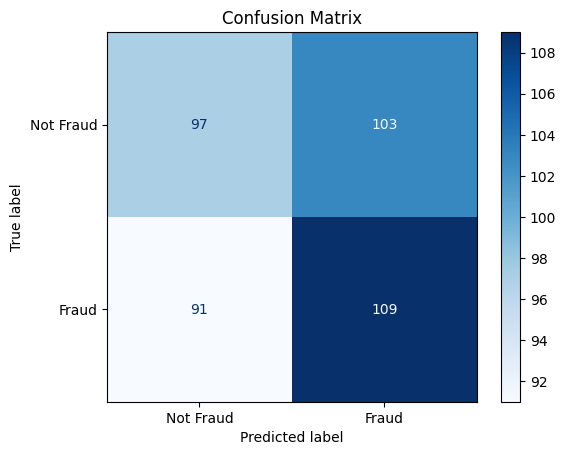

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    display_labels=["Not Fraud", "Fraud"],
    cmap="Blues",
    values_format="d"
)
plt.title("Confusion Matrix")
plt.show()

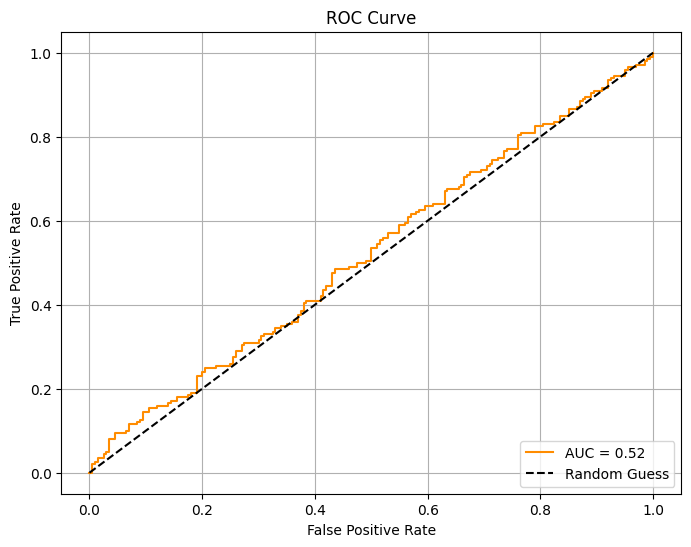

In [15]:
from sklearn.metrics import roc_curve, auc

y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

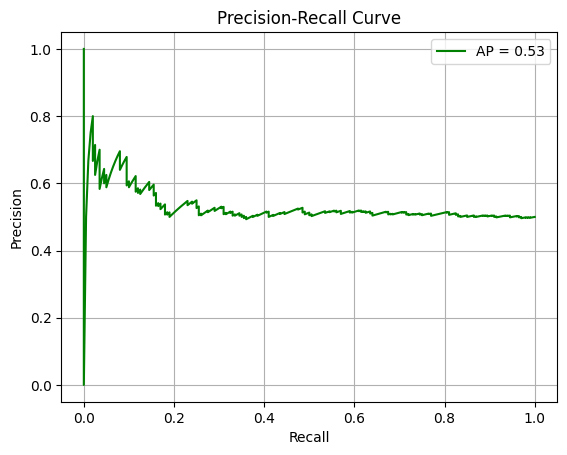

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

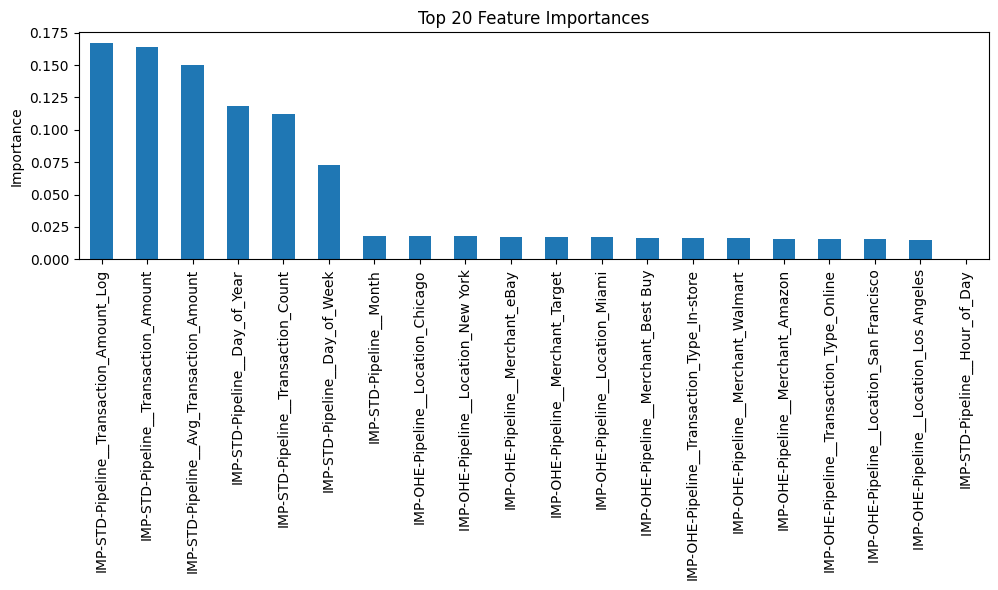

In [17]:
importances = best_model.named_steps['Tree_model'].feature_importances_
feature_names = best_model.named_steps['preprocessor_pipeline'].get_feature_names_out()
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()